# <center> 数据挖掘大作业：宇宙飞船泰坦尼克号 </center>

**import** 导入在过程当中可能会使用到的python包

In [3]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from imblearn.over_sampling import SMOTE
import itertools
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import time

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.utils import resample

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split


from lightgbm import LGBMClassifier
import lazypredict
from lazypredict.Supervised import LazyClassifier

import time
import warnings
warnings.filterwarnings('ignore')
print('Done')

Done


## 数据

**加载数据**

In [7]:
train = pd.read_csv('./train.csv') # 训练集
test = pd.read_csv('./test.csv')   # 测试集

print('Train set shape:', train.shape)
print('Test set shape:', test.shape)
train.head()

Train set shape: (8693, 14)
Test set shape: (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,6715.00,49.00,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,3329.00,193.00,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,2.00,Willy Santantines,True


**功能描述：**
- **PassengerId** - 每位乘客的唯一ID。每个ID的形式为gggg_pp，其中gggg表示乘客所在的组，pp表示该组中的编号。一个组中的人通常是家人，但不总是。
- **HomePlanet** - 乘客出发的星球，通常是他们的常驻星球。
- **CryoSleep** - 表示乘客是否选择在航行期间进入悬浮动画状态。处于悬浮动画状态的乘客被限制在自己的舱室内。
- **Cabin** - 乘客所居住的舱室号码。形式为deck/num/side，其中side可以是P（舷侧）或S（舷侧）。
- **Destination** - 乘客将要下船的星球。
- **Age** - 乘客的年龄。
- **VIP** - 乘客是否支付了豪华VIP服务费。
- **RoomService**，**FoodCourt**，**ShoppingMall**，**Spa**，**VRDeck** - 乘客在太空游轮“泰坦尼克号”上的许多奢华设施上的消费金额。
- **Name** - 乘客的名字和姓氏。
- **Transported** - 乘客是否被传送到另一个维度。这是目标，你要预测的列。


In [8]:
print(f'\033[94mNumber of rows in train data: {train.shape[0]}')
print(f'\033[94mNumber of columns in train data: {train.shape[1]}')
print(f'\033[94mNumber of values in train data: {train.count().sum()}')
print(f'\033[94mNumber missing values in train data: {sum(train.isna().sum())}')

Number of rows in train data: 8693
Number of columns in train data: 14
Number of values in train data: 119378
Number missing values in train data: 2324


查看每一行数据中出现缺失值的数量

In [9]:
print(f'\033[94m')
print(train.isna().sum().sort_values(ascending = False))


CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
Spa             183
FoodCourt       183
Destination     182
RoomService     181
Age             179
Transported       0
PassengerId       0
dtype: int64


检查数据集中有没有重复数据

In [10]:
print(f'\033[94m')
print(f'Duplicates in train set: {train.duplicated().sum()}, ({np.round(100*train.duplicated().sum()/len(train),1)}%)')
print('')
print(f'Duplicates in test set: {test.duplicated().sum()}, ({np.round(100*test.duplicated().sum()/len(test),1)}%)')


Duplicates in train set: 0, (0.0%)

Duplicates in test set: 0, (0.0%)


有上面可以看到数据集不错，里面是没有重复值出现的，但是缺失值确实不少，我们先来看看数据集中的特征，最后是需要对于缺失值进行处理的

In [11]:
train.nunique() # 训练集唯一值

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

In [12]:
train.dtypes # 训练集数据类型

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

在进行完数据处理之后需要将非数值型的数据转化成为数值型的数据，以便于模型的处理

## 探索性数据分析

分析目标的分布规律

Text(0.5, 1.0, 'Target_distribution')

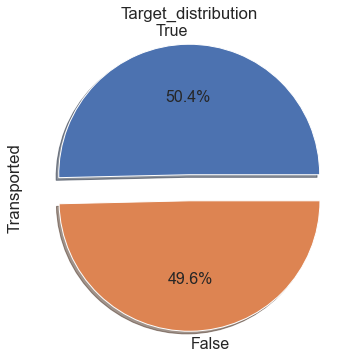

In [15]:
plt.figure(figsize=(6,6))

# Pie plot
train['Transported'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Target_distribution")

由上面的我们可以看到分布基本是对半分的，所以这个数据集是比较均衡的

**连续性特征**

Text(0.5, 0, 'Age (years)')

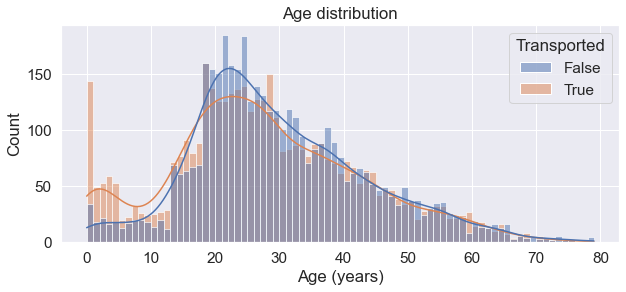

In [16]:
# Figure size
plt.figure(figsize=(10,4))

# 查看传送成功和不成功的样本的年龄分布
sns.histplot(data=train, x='Age', hue='Transported', binwidth=1, kde=True) # kde:核密度估计

plt.title('Age distribution')
plt.xlabel('Age (years)')

从中可以得到下面的结论：
+ 0-18岁的乘客中，传送成功的比例更高
+ 18-25岁的乘客中，传送成功的比例更低
+ 25岁以上的乘客中，传送成功的和不成功的比例基本相同

这给到我们一个启示可以按照三个年龄段对于数据进行划分，这样可以更好的进行模型的训练

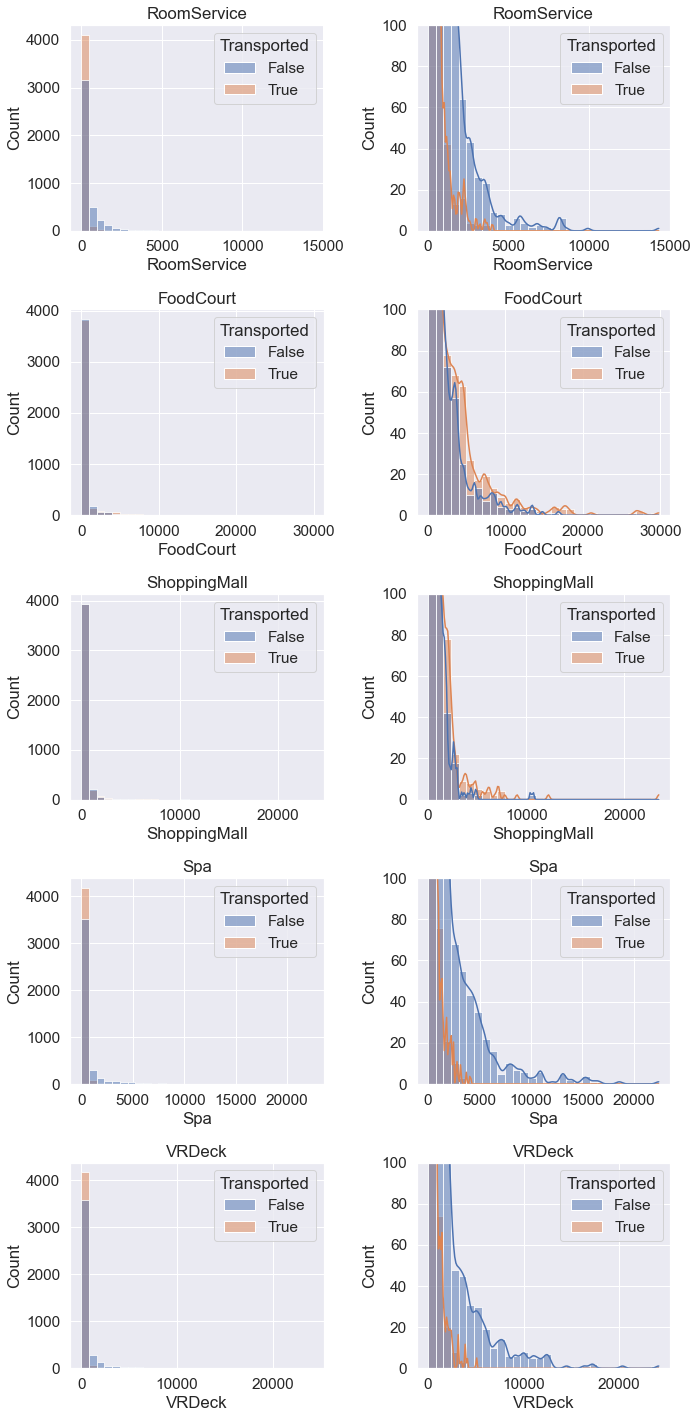

In [17]:
# Expenditure features 花费特征
exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Plot expenditure features
fig=plt.figure(figsize=(10,20))
for i, var_name in enumerate(exp_feats):
    # Left plot
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(var_name)

    # Right plot (truncated)
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=True, hue='Transported')
    plt.ylim([0,100])
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()